In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import RidgeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [20]:
df = pd.read_csv("Creditcard_data.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dataset Shape: (772, 31)

Class Distribution:
Class
0    0.988342
1    0.011658
Name: proportion, dtype: float64


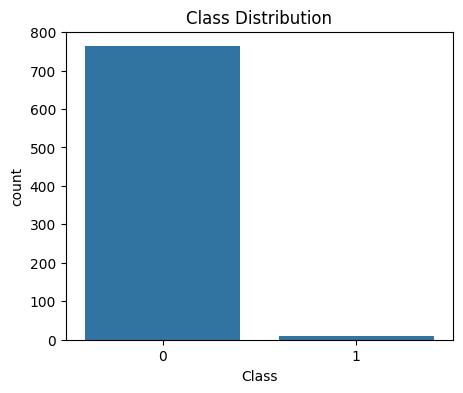

In [21]:
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["Class"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.show()


In [22]:
X = df.drop(columns=["Class"])
y = df["Class"]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=7
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [24]:
sampling_methods = {
    "Under_NearMiss": NearMiss(),
    "Over_SMOTE": SMOTE(k_neighbors=3, random_state=7),
    "Hybrid_SMOTETomek": SMOTETomek(random_state=7)
}


In [25]:
models = {
    "Ridge": RidgeClassifier(alpha=1.0),
    "ExtraTree": ExtraTreeClassifier(max_depth=10),
    "GradientBoost": GradientBoostingClassifier(n_estimators=150, learning_rate=0.05),
    "AdaBoost": AdaBoostClassifier(n_estimators=120),
    "NaiveBayes": GaussianNB()
}


In [26]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    return round(acc * 100, 2), round(f1 * 100, 2)


In [27]:
results_accuracy = pd.DataFrame(index=models.keys(), columns=sampling_methods.keys())
results_f1 = pd.DataFrame(index=models.keys(), columns=sampling_methods.keys())

for samp_name, sampler in sampling_methods.items():

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    for model_name, model in models.items():

        acc, f1 = evaluate_model(
            model, X_resampled, y_resampled, X_test, y_test
        )

        results_accuracy.loc[model_name, samp_name] = acc
        results_f1.loc[model_name, samp_name] = f1


In [28]:
print("Accuracy Table")
results_accuracy


Accuracy Table


,Under_NearMiss,Over_SMOTE,Hybrid_SMOTETomek
Ridge,21.55,80.6,82.33
ExtraTree,16.81,87.93,84.05
GradientBoost,34.05,98.28,98.28
AdaBoost,38.79,98.71,98.28
NaiveBayes,6.47,74.57,72.84


In [29]:
print("F1 Score Table")
results_f1


F1 Score Table


,Under_NearMiss,Over_SMOTE,Hybrid_SMOTETomek
Ridge,3.19,4.26,4.65
ExtraTree,3.02,6.67,0.0
GradientBoost,1.29,0.0,0.0
AdaBoost,1.39,0.0,0.0
NaiveBayes,1.81,3.28,3.08


In [30]:
results_accuracy.to_csv("modified_accuracy_table.csv")
results_f1.to_csv("modified_f1score_table.csv")


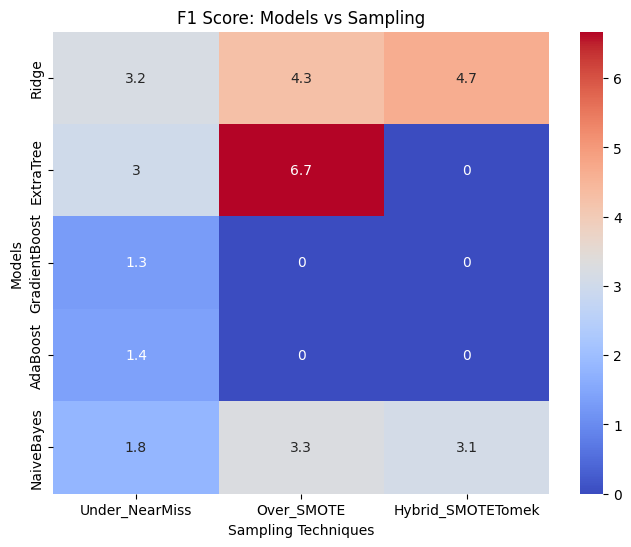

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(results_f1.astype(float), annot=True, cmap="coolwarm")
plt.title("F1 Score: Models vs Sampling")
plt.ylabel("Models")
plt.xlabel("Sampling Techniques")
plt.show()


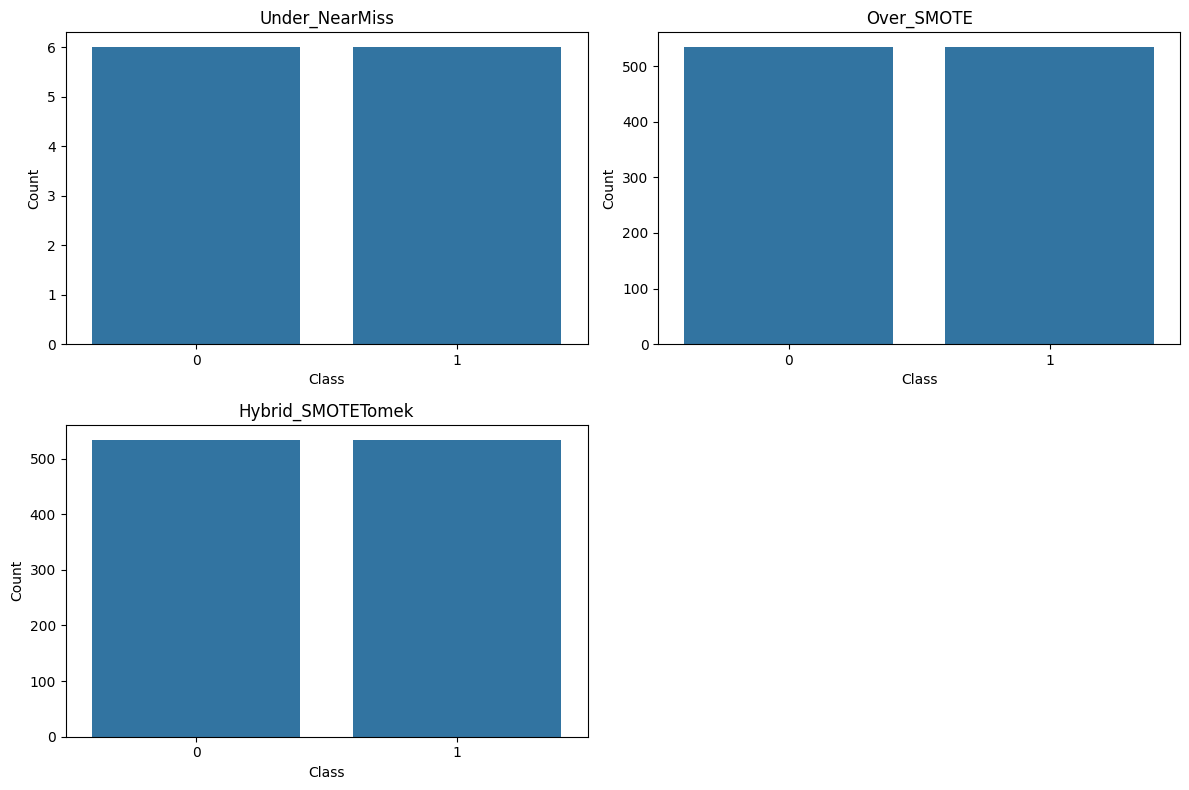

In [32]:
plt.figure(figsize=(12, 8))

for i, (name, sampler) in enumerate(sampling_methods.items(), 1):

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    plt.subplot(2, 2, i)
    sns.countplot(x=y_resampled)
    plt.title(f"{name}")
    plt.xlabel("Class")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()
